# Set Variables

In [ ]:
# -------- outp_version
output_version = 1092
top_k = 20

# -------- dataset
# software_name = "Camel"
# software_name = "CloudStack"
software_name = "Geode"
# software_name = "Hbase"

In [ ]:
dataset_file_names = {
    "Camel":      "Camel_Bugs - v.01",
    "CloudStack": "CloudStack_Bugs - v.01",
    "Geode":      "Geode_Bugs - v.01",
    "Hbase":      "Hbase_Bugs - v.03"
}

dataset_file_name = dataset_file_names[software_name]

# Google Colab

In [ ]:
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load data from google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
!ls "/content/gdrive/My Drive/"

Mounted at /content/gdrive
'Colab Notebooks'   SAVE


In [ ]:
# project folder path
project_folder = "gdrive/MyDrive/Colab Notebooks/paper/"

# data folder path
data_folder = "00- My Data/two-phase method/"

# dataset folder path
dataset_folder = software_name + "/"

# output folder path
output_folder = "01- Jupyter Notebook/80- two-phase method/00. Output/"

# Libs

In [ ]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from operator import truediv

# Config

In [ ]:
mypaths = {
    "output": {
        "performance": project_folder + output_folder + dataset_folder + dataset_file_name + "/top-k/k={}/performance-v{}.json"
    }
}

In [ ]:
mypaths["output"]["performance"] = mypaths["output"]["performance"].format(
    top_k,
    output_version
)

In [ ]:
print(mypaths["output"]["performance"])

gdrive/MyDrive/Colab Notebooks/paper/01- Jupyter Notebook/04- two-phased method/00. Output/Geode/Geode_Bugs - v.01/top-k/k=20/performance-v1092.json


# ClassDistribution

In [ ]:
class ClassDistribution:
    
    def __init__(self, df_bug_pred):
        self.df_bug_pred = df_bug_pred
        self.my_bug_classes = ["bug_class_2"]
        self.bug_label_num = {}
        self.bug_label_per = {}
        self.bug_label_ratio = {}
        
        for i, bug_class in enumerate(self.my_bug_classes):
            if i == 0: # bug_label_2
                self.bug_label_num[bug_class] =   {"0": 0, "1":  0}
                self.bug_label_per[bug_class] =   {"0": 0, "1":  0}
                self.bug_label_ratio[bug_class] = {}
        
        # plot values
        self.colours = ["red", "blue", "green", "cyan"]
    
    
    # --------------------------- calc_bug_label_num
    
    def calc_bug_label_num_per(self):
        self.df_bug_pred.groupby("bug_class_2").apply(lambda g: self.sub_bln_(g, "bug_class_2"))
    
    
    def sub_bln_(self, g, gby):
        self.bug_label_num[gby][str(g.name)] = len(g)
        self.bug_label_per[gby][str(g.name)] = (len(g) / len(self.df_bug_pred)) * 100
    
    
    # --------------------------- calc_ratios
    
    def calc_bug_label_ratios(self):
        
        for bug_class in self.my_bug_classes:
            temp = self.bug_label_num[bug_class]
            mydata_sorted = [(key, value) for key, value in sorted(temp.items(), 
                                                                   key=lambda item: item[1], reverse=True)]
        
            num_classes = len(temp)
            for i in range(num_classes - 1):
                for j in range(i + 1, num_classes):
                    tempKey1 = mydata_sorted[i][0]
                    tempKey2 = mydata_sorted[j][0]
                    mykey = tempKey1 + "/" + tempKey2

                    tempValue1 = mydata_sorted[i][1]
                    tempValue2 = mydata_sorted[j][1]
                    if tempValue2 != 0:
                        self.bug_label_ratio[bug_class][mykey] = tempValue1 / tempValue2
    
    
    # --------------------------- bar plot
    
    def plot_percent_num(self, bla, th, num_bugs):
        # figsize=(a, b) : a_width, b_height
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        width = 0.2
        my_x = [-0.3, -0.1, 0.1, 0.3]
        
        temp1 = str(num_bugs)
        temp2 = len(temp1) - 1
        temp3 = "1" + "0" * temp2
        temp4 = temp1[0] + "0" * temp2
        temp5 = int(temp3) + int(temp4)
        
        ml = list( range(0, temp5, int(temp3)) )
        ml.append(num_bugs)
        
        for i, key in enumerate(self.my_bug_classes):
            ax1 = axes[0]
            ax2 = axes[1]
            for j, cl in enumerate(self.bug_label_per[key]):
                ax1.bar(my_x[j], self.bug_label_num[key][cl], width=width, label=cl, color=self.colours[j])
                ax2.bar(my_x[j], self.bug_label_per[key][cl], width=width, label=cl, color=self.colours[j])
            
            tempXlabel = "{}".format(key)
            ax1.set_xlabel(tempXlabel)
            ax2.set_xlabel(tempXlabel)
            
            ax1.set_ylabel("Number of Bug Reports")
            ax2.set_ylabel("Percentages (%)")
            
            tempXlim = [-0.5, 0.5]
            ax1.set_xlim(tempXlim)
            ax2.set_xlim(tempXlim)
            
            
            ax1.set_ylim([0, temp5])
            ax2.set_ylim([0, 110])
            
            
            ax1.get_xaxis().set_ticks([])
            ax2.get_xaxis().set_ticks([])
            
            
            ax1.get_yaxis().set_ticks(ml)
            ax2.get_yaxis().set_ticks(list(range(0, 101, 10)))
            
            ax1.legend()
            ax2.legend()
            
            ax1.grid(axis="y")
            ax2.grid(axis="y")
        
        fig.suptitle("bla: {}, th: {}".format(bla, th), fontsize=16)
        fig.tight_layout(pad=3.0)
    
    
    def free_memory(self):
        self.df_bug_pred = None

# CalculateMetrics

In [ ]:
class CalculateMetrics():
    def __init__(self, cm):
        self.cm = cm
        self.true_positives = np.diag(cm)
    
    
    # calculate precision for each class
    def calc_precision(self):
        columns_sum = np.sum(self.cm, axis=0)
        prec = list(map(truediv, self.true_positives, columns_sum))
        self.precision = prec
        return prec
    
    
    # calculate recall for each class
    def calc_recall(self):
        rows_sum = np.sum(self.cm, axis=1)
        rec = list(map(truediv, self.true_positives, rows_sum))
        self.recall = rec
        return rec
    
    
    # calculate f1_score for each class
    def calc_f1_score(self):
        tempPrec = np.array(self.precision)
        tempRec = np.array(self.recall)
        numerator = tempPrec * tempRec
        Denominator = tempPrec + tempRec
        f1s = 2 * (numerator / Denominator)
        self.f1_score = f1s
        return f1s

# Plot results

In [ ]:
with open(mypaths["output"]["performance"]) as filehandle:
    my_whole_data = json.load(filehandle)

In [ ]:
class PlotResults:
    
    def __init__(self):
        self.ls = "solid"
        self.lw = 1
        self.marker = "."
        self.colours = {
            "simple": "red",
            "bc_2":   "blue",
        }
        
    # --------------------------- helpers
    
    def y_th_(self):
        return {th: [] for th in self.threshold}
    
    
    def y_bla_(self):
        return {bla: [] for bla in self.bla}
    
    
    def load_results(self, whole_data):
        self.bla = whole_data["bug_localization_accuracy"]
        self.threshold = whole_data["knn_accuracy_threshold"]
        self.samples_num = whole_data["samples_num"]
        self.samples_num_pred = whole_data["samples_num_pred"]
        self.brIDs_num = whole_data["brIDs_num"]
        self.brIDs_num_pred = whole_data["brIDs_num_pred"]
        
        self.cf = whole_data["confusion_matrix"]
        
        self.nplot = len(self.threshold)
        
        self.df_data_bug_class_distribution = whole_data["df_data_bug_class_distribution"]
        self.accuracies = whole_data["accuracies"]
        
        self.df = pd.DataFrame({
            "bla":              pd.Series(dtype="float64"),
            "th":               pd.Series(dtype="float64"),
            "samples_num_pred": pd.Series(dtype="int64"),
            "samples_percent":  pd.Series(dtype="int32"),
            "brIDs_num_pred":   pd.Series(dtype="int64"),
            "brIDs_percent":    pd.Series(dtype="int32")
        })
        
        self.y_values_const_th = {
            "simple": self.y_th_(),
            "bc_2":   self.y_th_(),
        }
        
        self.y_values_const_bla = {
            "simple": self.y_bla_(),
            "bc_2":   self.y_bla_(),
        }
        
        
        
        for b in self.bla:
            for th in self.threshold:
                # --- df_samples
                samples_num_pred = whole_data["samples_num_pred"][str(b)][str(th)]
                samples_percent = round((samples_num_pred / self.samples_num) * 100)
                
                brIDs_num_pred = whole_data["brIDs_num_pred"][str(b)][str(th)]
                brIDs_percent = round((brIDs_num_pred / self.brIDs_num) * 100)
                
                self.df = self.df.append(
                    {
                        "bla": b, 
                        "th": th, 
                        "samples_num_pred": int(samples_num_pred), 
                        "samples_percent": int(samples_percent),
                        "brIDs_num_pred": int(brIDs_num_pred), 
                        "brIDs_percent": int(brIDs_percent)
                    }, 
                    ignore_index=True
                )
                
                # --- y_values_const_th
                for key, value in self.y_values_const_th.items():
                    value[th].append(whole_data["accuracies"][str(b)][str(th)][key])
                
                for key, value in self.y_values_const_bla.items():
                    value[b].append(whole_data["accuracies"][str(b)][str(th)][key])
    
    
    def my_max(self):
        my_max_acc = {"bla": None, "th": None, "acc": 0}
        for bla in self.bla:
            for th in self.threshold:
                tempAcc = self.accuracies[str(bla)][str(th)]["bc_2"]
                if tempAcc > my_max_acc["acc"]:
                    my_max_acc["acc"] = round(tempAcc, 1)
                    my_max_acc["bla"] = bla
                    my_max_acc["th"] = th
        print("bla: ", my_max_acc["bla"])
        print("th: ", my_max_acc["th"])
        print()
        self.get_brids_samples_num_pred_num_perc(my_max_acc["bla"], my_max_acc["th"])
        print()
        print("acc: ", my_max_acc["acc"])
        print()
        self.get_precision_recall_f1score(my_max_acc["bla"], my_max_acc["th"])
    
    
    def my_acc_bt(self, bla, th):
        print("bla: ", bla)
        print("th: ", th)
        print()
        self.get_brids_samples_num_pred_num_perc(bla, th)
        print()
        tempAcc = self.accuracies[str(bla)][str(th)]["bc_2"]
        print("acc: ", round(tempAcc))
        print()
        self.get_precision_recall_f1score(bla, th)
    
    
    def calc_precision_recall_f1score(self, doprint=False):
        self.precision = {}
        self.recall = {}
        self.f1_score = {}
        
        for bla in self.bla:
            self.precision[bla] = {}
            self.recall[bla] = {}
            self.f1_score[bla] = {}
            
            for th in self.threshold:
                cf_matrix = self.cf[str(bla)][str(th)]["confusion_matrix"]
                cf_matrix = np.array(cf_matrix)

                calcmet = CalculateMetrics(cf_matrix)
                precision = calcmet.calc_precision()
                self.precision[bla][th] = [round(elem * 100, 0) for elem in precision]

                recall = calcmet.calc_recall()
                self.recall[bla][th] = [round(elem * 100, 0) for elem in recall]

                f1_score = calcmet.calc_f1_score()
                self.f1_score[bla][th] = [round(elem * 100, 0) for elem in f1_score]
    
    
    def print_all_prf(self):
        for bla in self.bla:
            for th in self.threshold:
                print("-" * 15, "bla: {}, th: {}".format(bla, th))
                print("precision: ", self.precision[bla][th])
                print("recall:    ", self.recall[bla][th])
                print("f1_score:  ", self.f1_score[bla][th])
    
    
    def get_precision_recall_f1score(self, bla, th):
        print("-" * 15, "bla: {}, th: {}".format(bla, th))
        print("precision: ", self.precision[bla][th])
        print("recall:    ", self.recall[bla][th])
        print("f1_score:  ", self.f1_score[bla][th])
    
    
    def plot_confusion_matrices(self):
        for bla in self.bla:
            # print("\n", "*" * 30, "bla: ", bla)
            no_rows = round(len(self.threshold) / 2)
            fig_cf, axes_cd = plt.subplots(nrows=no_rows, ncols=2, figsize=(7, 14))
            fig_cf.suptitle("Seaborn Confusion Matrix with labels")
            fig_cf.supxlabel("--Predicted-- Bug Report Category")
            fig_cf.supylabel("--Actual-- Bug Report Category")

            i = 0
            my_row = 0
            my_col = 0
        
            for j, th in enumerate(self.threshold):
                cfax = axes_cd[my_row][my_col]
                mycbar = True
    #             if datasetName == "train":
    #                 mycbar = True
    #             else:
    #                 mycbar = False

                cf_matrix = self.cf[str(bla)][str(th)]["confusion_matrix"]
                cf_matrix = np.array(cf_matrix)
            
                precision = self.precision[bla][th]
                recall = self.recall[bla][th]
                f1_score = self.f1_score[bla][th]

#                 print("-" * 15, "bla: {}, th: {}".format(b, th))
#                 print("precision: ", precision)
#                 print("recall:    ", recall)
#                 print("f1_score:  ", f1_score)

                snax = sns.heatmap(cf_matrix / np.sum(cf_matrix), 
                                   annot=True, fmt=".2%", cmap="Blues", ax=cfax, vmin=0, vmax=1, 
                                   cbar=mycbar, annot_kws={"size": 12})

                
                snax.set_title("[bla:{} _ th:{}]\n".format(bla, th))
                

                labels = list(map(str, [0, 1]))

                snax.xaxis.set_ticklabels(labels)
                snax.yaxis.set_ticklabels(labels)
                i += 1
                
                if (j % 2 != 0):
                    my_row += 1
                    my_col = 0
                else:
                    my_col = 1
                
            # --- end for th
            fig_cf.tight_layout(w_pad=6.0)
    
    
    def percal_samples_brid(self):
        self.samples_num_pred_perc = {}
        self.brIDs_num_pred_perc = {}
        
        for bla in self.bla:
            self.samples_num_pred_perc[bla] = {}
            self.brIDs_num_pred_perc[bla] = {}
            
            for th in self.threshold:
                tempSample = self.samples_num_pred[str(bla)][str(th)] / self.samples_num
                tempBrid = self.brIDs_num_pred[str(bla)][str(th)] / self.brIDs_num
                
                tempSample = tempSample * 100
                tempBrid = tempBrid * 100
                
                self.samples_num_pred_perc[bla][th] = round(tempSample, 1)
                self.brIDs_num_pred_perc[bla][th] = round(tempBrid, 1)
    
    def get_brids_samples_num_pred_num_perc(self, bla, th):
        print("samples num pred:  ", self.samples_num_pred[str(bla)][str(th)])
        print("samples perc pred: ", round(self.samples_num_pred_perc[bla][th]))
        print()
        print("brIDs num pred:  ", self.brIDs_num_pred[str(bla)][str(th)])
        print("brIDs perc pred: ", round(self.brIDs_num_pred_perc[bla][th]))
    
    
    def print_all_samples_num_pred_perc(self):
        for bla in self.bla:
            print("**bla=", bla)
            for th in self.threshold:
                print(th, self.samples_num_pred_perc[bla][th])
            print("-" * 10)
    
    
    def print_all_brIDs_num_pred_perc(self):
        for bla in self.bla:
            print("**bla=", bla)
            for th in self.threshold:
                print(th, self.brIDs_num_pred_perc[bla][th])
            print("-" * 10)
    
    
    # --------------------------- plot_acc_const_th | linear plot
    
    def plot_acc_const_th(self):
        my_fig_height = 18
        temp1 = my_fig_height / 5
        temp2 = temp1 * self.nplot
        # figsize=(a, b) : a_width, b_height
        fig, axes = plt.subplots(nrows=self.nplot, ncols=1, figsize=(9, temp2))
        if self.nplot == 1:
            axes = [axes]
            
        for ax, th in zip(axes, self.threshold):
            for key, value in self.y_values_const_th.items():
                ax.plot(self.bla, 
                        value[th], 
                        label=key, 
                        color=self.colours[key], 
                        linestyle=self.ls, 
                        lw=self.lw, 
                        marker=self.marker)
            
            ax.set_title(self.set_title_const_th_(th))
            ax.set_xlabel("Bug Localization Accuracy")
            ax.set_ylabel("Total accuracy")
            
            ax.set_xlim([0.3, 1.05])
            ax.get_xaxis().set_ticks(self.bla)
            
            ax.set_ylim([0, 110])
            ax.get_yaxis().set_ticks(list(range(0, 101, 10)))
            
            ax.legend()
            ax.grid(True)
        # --- end for
        
        fig.tight_layout(pad=3.0)
    
    def set_title_const_th_(self, th_gname):
        tempstr = "-" * 5
        my_title = tempstr + " KNN Accuracy Threshold: " + str(th_gname) + " " + tempstr
        return my_title
    
    
    # --------------------------- plot_acc_const_bla | linear plot
    
    def plot_acc_const_bla(self):
        my_nplot = len(self.bla)
        my_fig_height = 18
        temp1 = my_fig_height / 5
        temp2 = temp1 * my_nplot
        # figsize=(a, b) : a_width, b_height
        fig, axes = plt.subplots(nrows=my_nplot, ncols=1, figsize=(9, temp2))
        if my_nplot == 1:
            axes = [axes]
        
        for ax, bla in zip(axes, self.bla):
            for key, value in self.y_values_const_bla.items():
                ax.plot(self.threshold, 
                        value[bla], 
                        label=key, 
                        color=self.colours[key], 
                        linestyle=self.ls, 
                        lw=self.lw, 
                        marker=self.marker)
            
            ax.set_title(self.set_title_const_bla_(bla))
            ax.set_xlabel("KNN Accuracy Threshold")
            ax.set_ylabel("Total accuracy")
            
            ax.set_xlim([0.3, 1.05])
            ax.get_xaxis().set_ticks(self.threshold)
            
            ax.set_ylim([0, 110])
            ax.get_yaxis().set_ticks(list(range(0, 101, 10)))
            
            ax.legend()
            ax.grid(True)
        # --- end for
        
        fig.tight_layout(pad=3.0)
        
    def set_title_const_bla_(self, bla_name):
        tempstr = "-" * 5
        my_title = tempstr + " Bug Localization Accuracy: " + str(bla_name) + " " + tempstr
        return my_title
    
    
    # --------------------------- plot_percent_num | bar plot
    
    def plot_percent_num(self):
        my_fig_height = 18
        temp1 = my_fig_height / 5
        temp2 = temp1 * self.nplot
        fig, axes = plt.subplots(nrows=self.nplot, ncols=1, figsize=(9, temp2))
        if self.nplot == 1:
            axes = [axes]
        self.counter = 0
        self.df.groupby("th").apply(lambda g: self.plot_flow_percent_(g, axes[self.counter]))
        fig.tight_layout(pad=3.0)
    
    
    def plot_flow_percent_(self, g, ax):
        x_axis = np.arange(len(self.bla))
        width = 0.4
        ax.bar(x_axis - 0.2, g["samples_percent"], width=width, label="Samples", color="#1F77B4") # blue
        ax.bar(x_axis + 0.2, g["brIDs_percent"], width=width, label="Bug Report IDs", color="#FF7F0E") # orange
        
        ax.set_title(self.set_title_const_th_(g.name))
        ax.set_xlabel("Bug Localization Accuracy")
        ax.set_ylabel("Percentages (%)")
        
        ax.get_xaxis().set_ticks(x_axis, self.bla)
        
        ax.set_ylim([0, 110])
        ax.get_yaxis().set_ticks(list(range(0, 101, 10)))
        
        ax.legend()
        ax.grid(axis="y")
        
        self.counter += 1
    
    
    # --------------------------- plot_class_distribution
    
    def plot_class_distribution(self):
        for i, bla in enumerate(self.bla):
            for j, th in enumerate(self.threshold):
                key_bla = str(bla)
                key_th = str(th)
                #print(j)
                #print(self.df_data_bug_class_distribution[str(bla)][str(th)]["bug_label_num"])
                tempBP = ClassDistribution(None)
                tempBP.bug_label_num = self.df_data_bug_class_distribution[key_bla][key_th]["bug_class_num"]
                tempBP.bug_label_per = self.df_data_bug_class_distribution[key_bla][key_th]["bug_class_per"]
                tempBP.bug_label_ratio = self.df_data_bug_class_distribution[key_bla][key_th]["bug_class_ratio"]
                tempBP.plot_percent_num(bla, th, self.brIDs_num_pred[key_bla][key_th])

## obj

In [ ]:
pr = PlotResults()
pr.load_results(my_whole_data.copy())

In [ ]:
pr.calc_precision_recall_f1score(doprint=False)
pr.percal_samples_brid()

In [ ]:
print(pr.df_data_bug_class_distribution["0.8"]["0.95"]["bug_class_num"])
print(pr.df_data_bug_class_distribution["0.8"]["0.95"]["bug_class_per"])
print(pr.df_data_bug_class_distribution["0.8"]["0.95"]["bug_class_ratio"])

{'bug_class_2': {'0': 574, '1': 178}}
{'bug_class_2': {'0': 76.32978723404256, '1': 23.670212765957448}}
{'bug_class_2': {'0/1': 3.2247191011235956}}


In [ ]:
# pr.get_brids_samples_num_pred_num_perc(0.8, 0.95)

In [ ]:
# pr.print_all_prf()

In [ ]:
# pr.print_all_samples_num_pred_perc()

In [ ]:
# pr.print_all_brIDs_num_pred_perc()

In [ ]:
pr.my_acc_bt(0.8, 0.95)

bla:  0.8
th:  0.95

samples num pred:   3941
samples perc pred:  14

brIDs num pred:   752
brIDs perc pred:  21

acc:  76

--------------- bla: 0.8, th: 0.95
precision:  [77.0, 50.0]
recall:     [98.0, 6.0]
f1_score:   [86.0, 10.0]


In [ ]:
pr.my_max()

bla:  0.8
th:  0.95

samples num pred:   3941
samples perc pred:  14

brIDs num pred:   752
brIDs perc pred:  21

acc:  76.3

--------------- bla: 0.8, th: 0.95
precision:  [77.0, 50.0]
recall:     [98.0, 6.0]
f1_score:   [86.0, 10.0]


## confusion_matrices

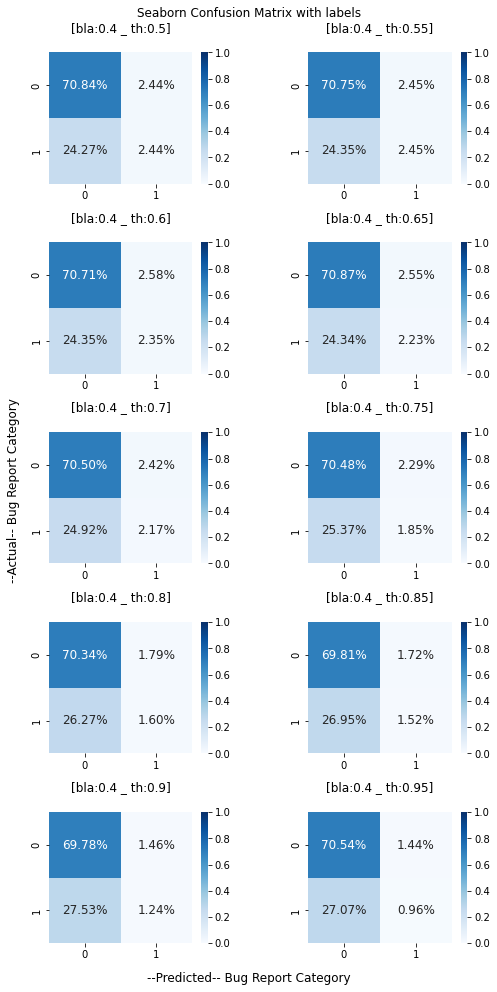

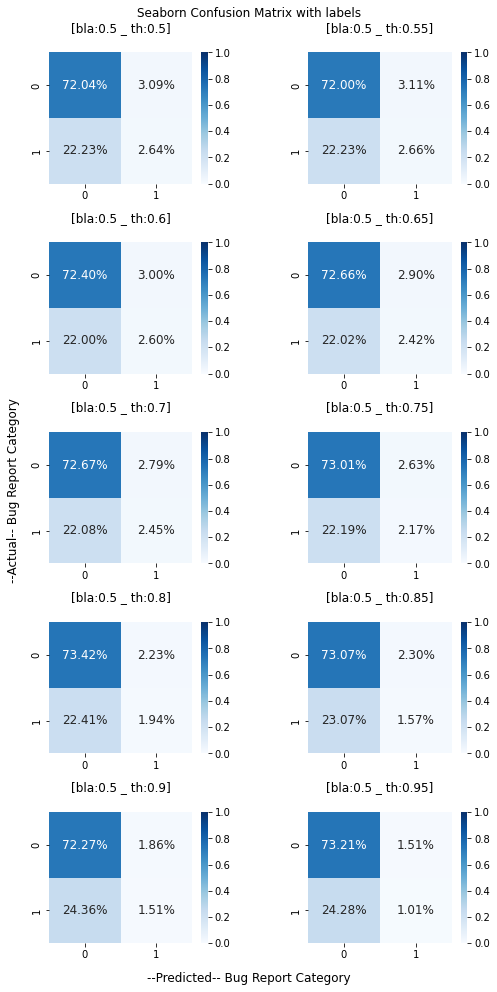

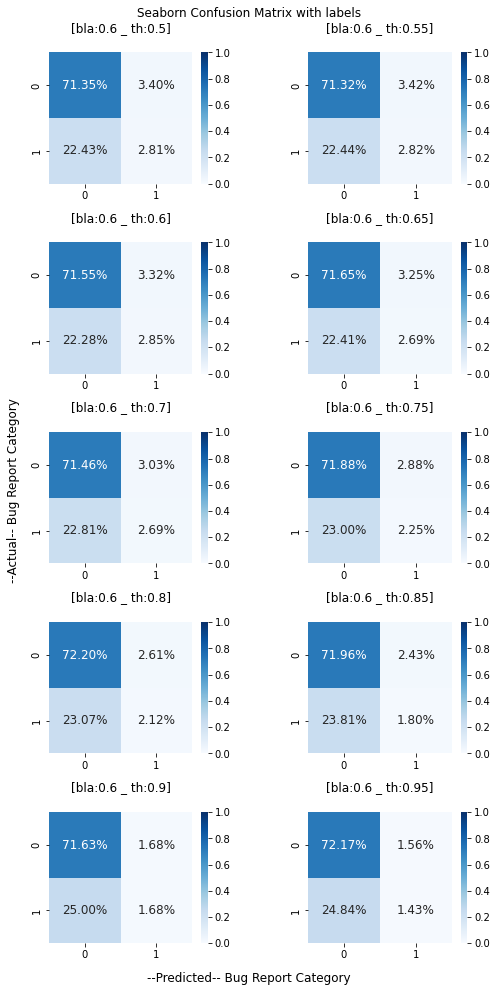

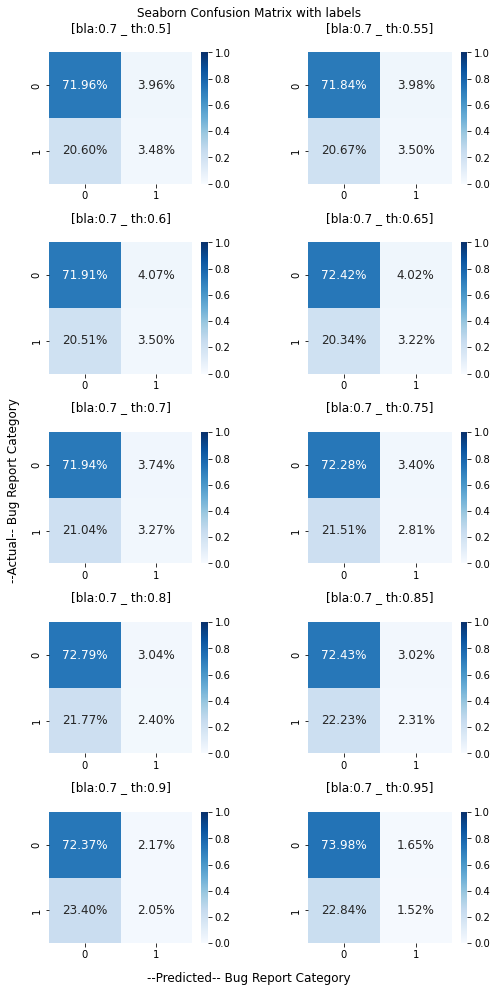

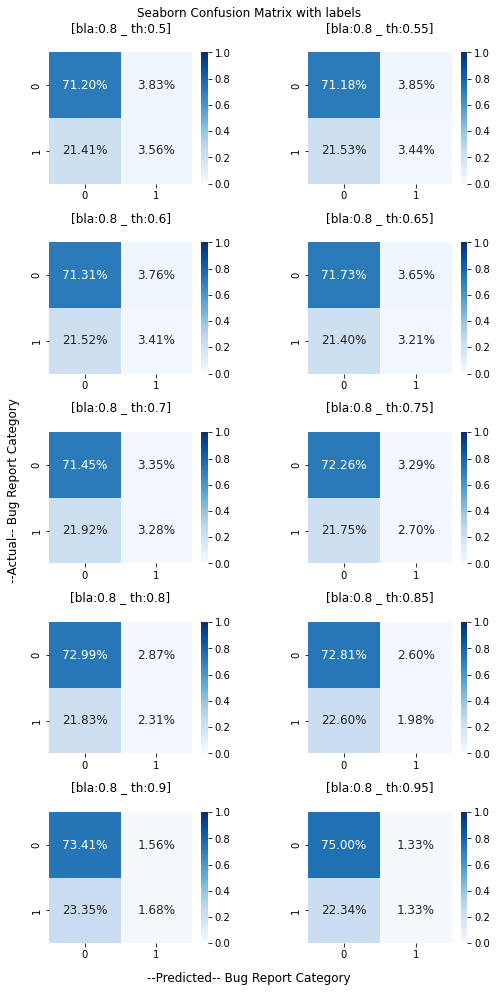

In [ ]:
pr.plot_confusion_matrices()

## acc_const_th

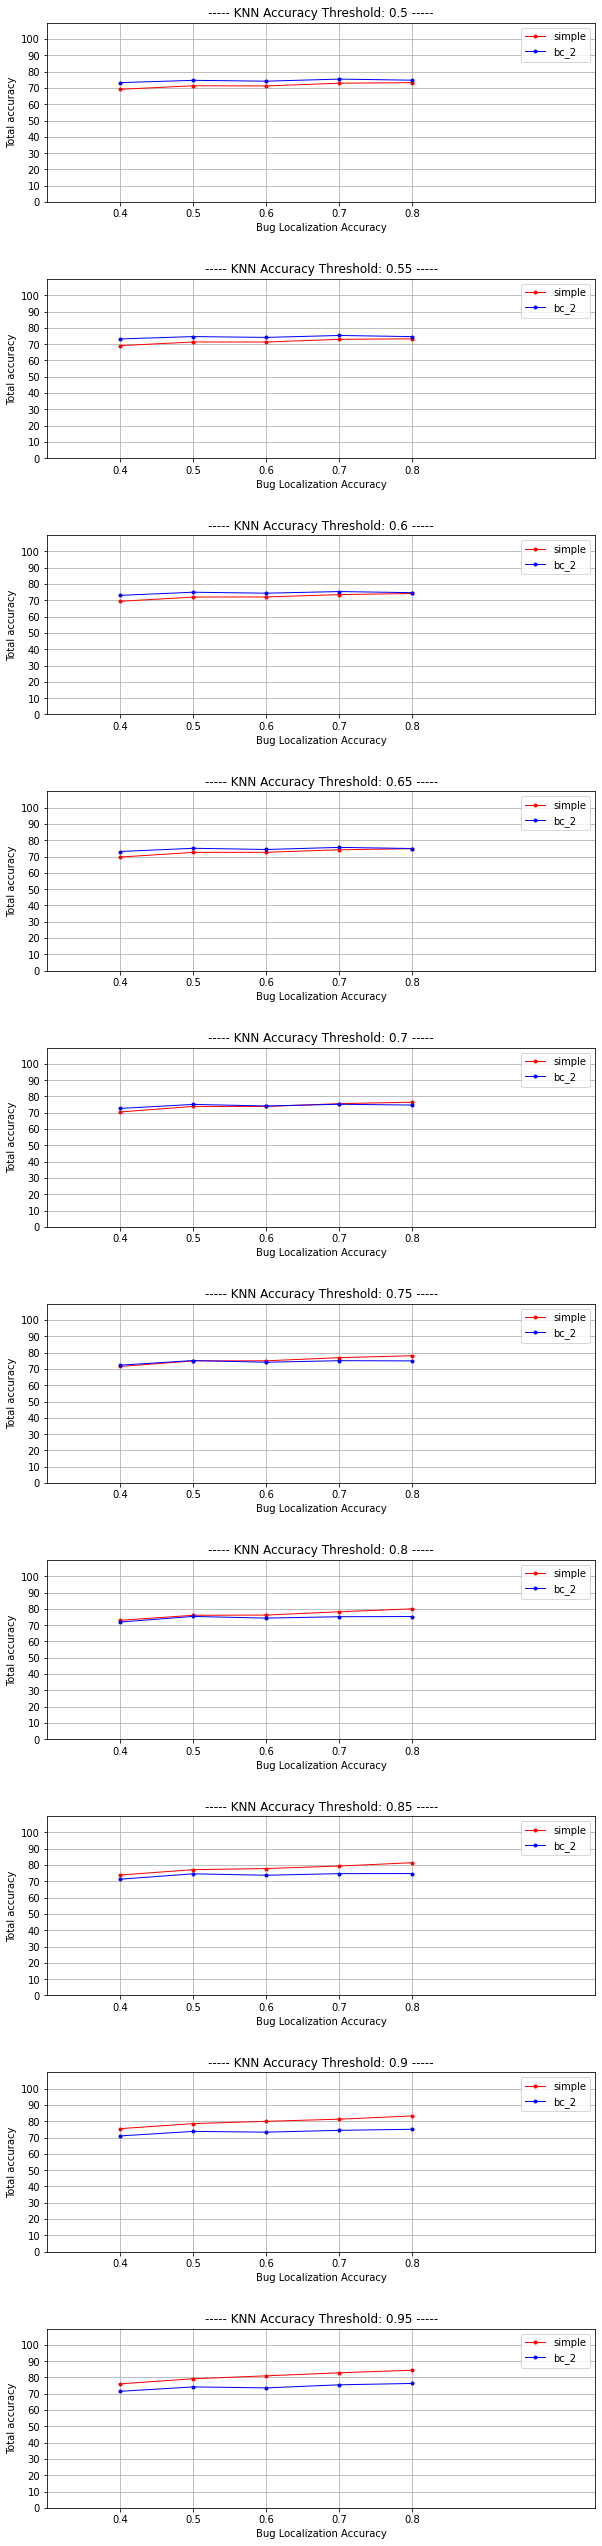

In [ ]:
pr.plot_acc_const_th()

## acc_const_bla

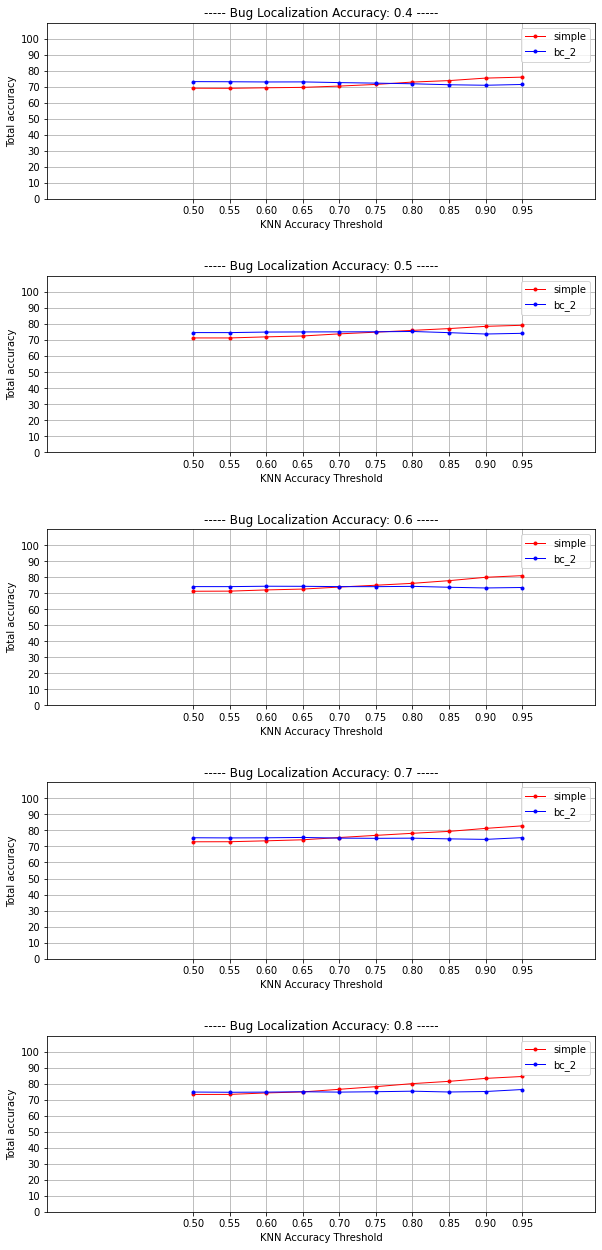

In [ ]:
pr.plot_acc_const_bla()

## percent_num

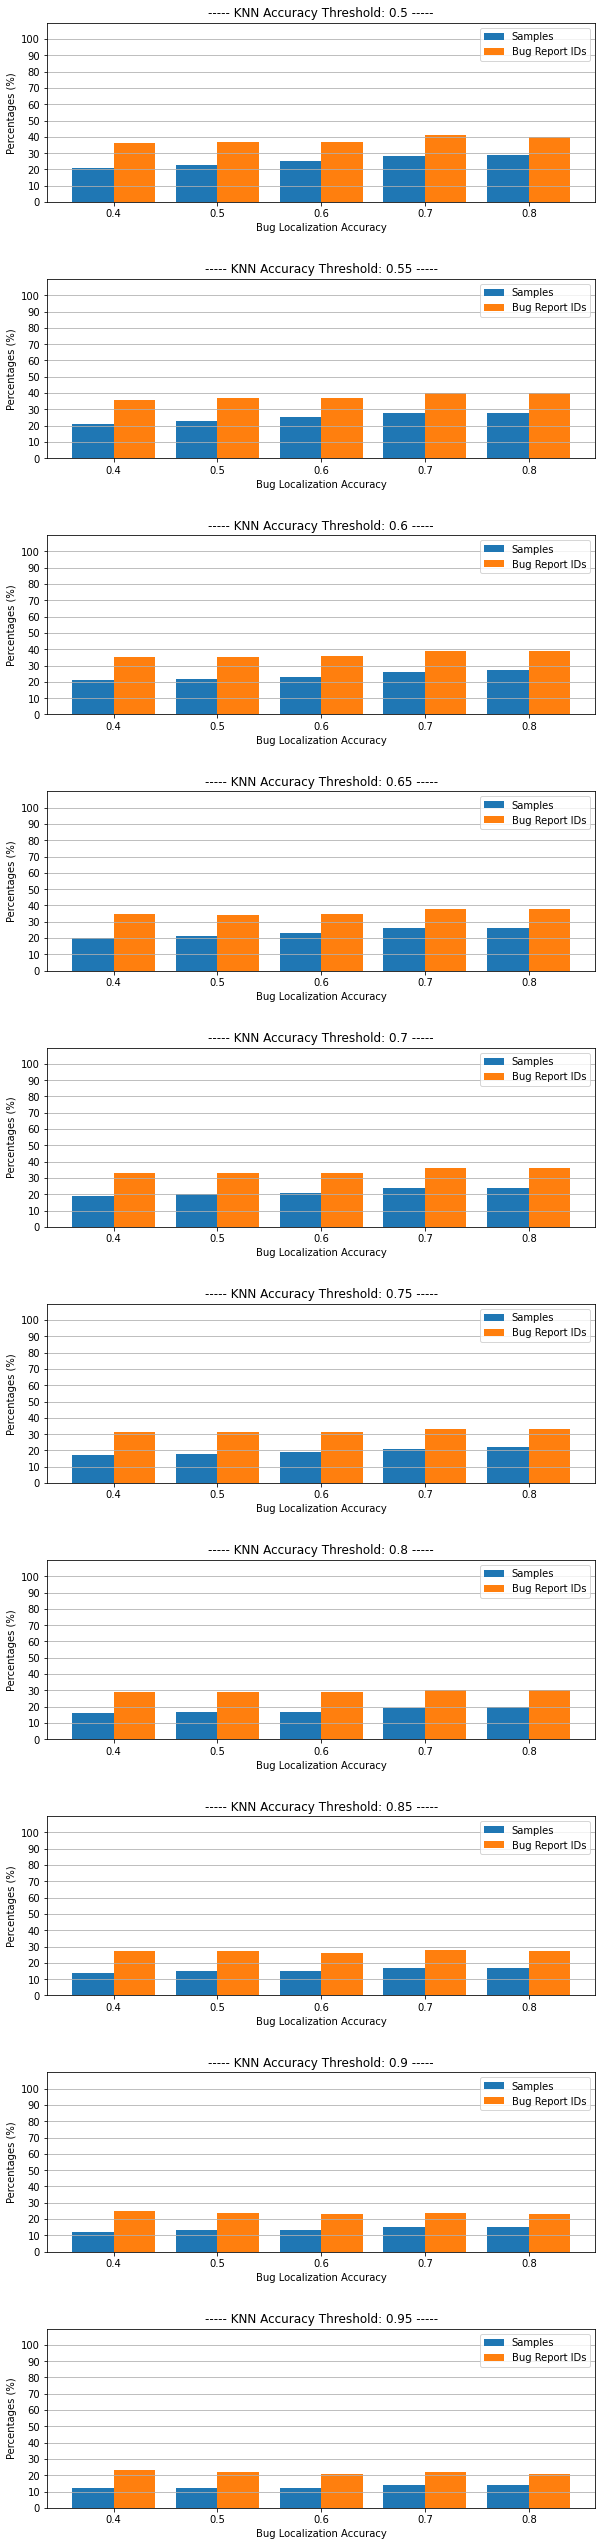

In [ ]:
pr.plot_percent_num()

## class_distribution

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


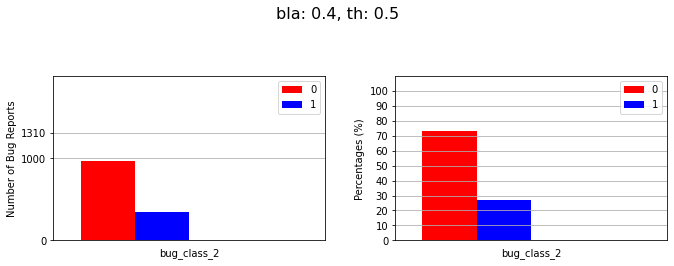

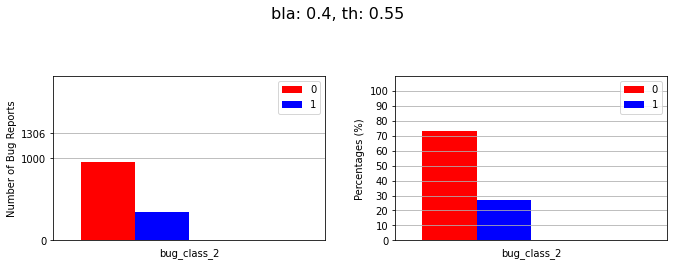

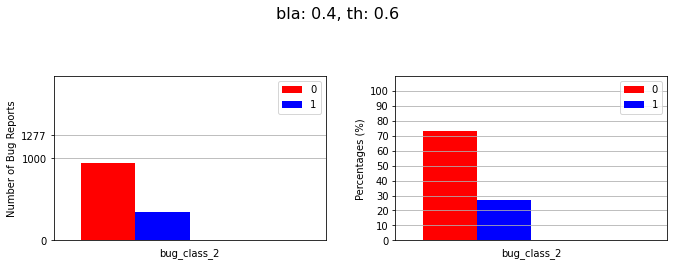

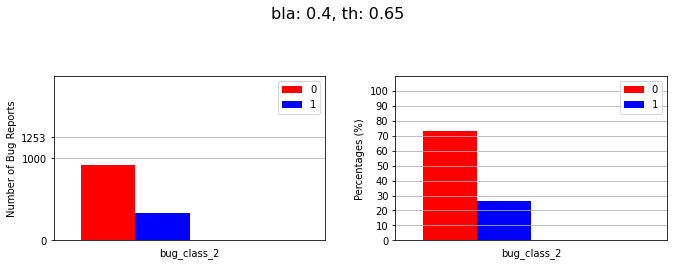

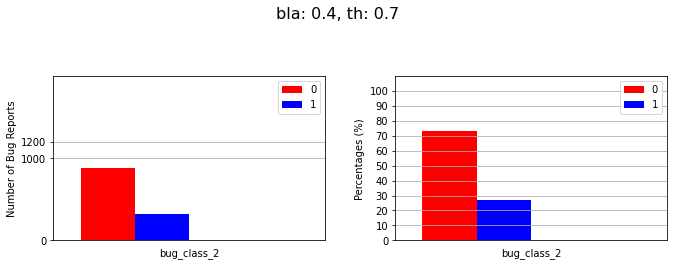

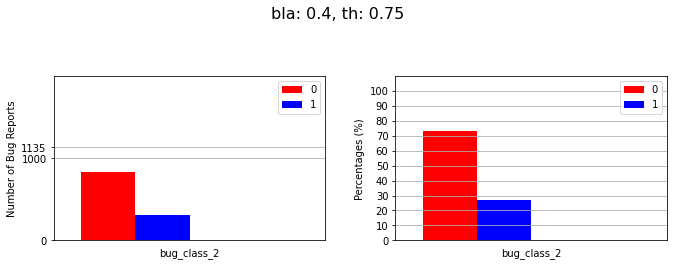

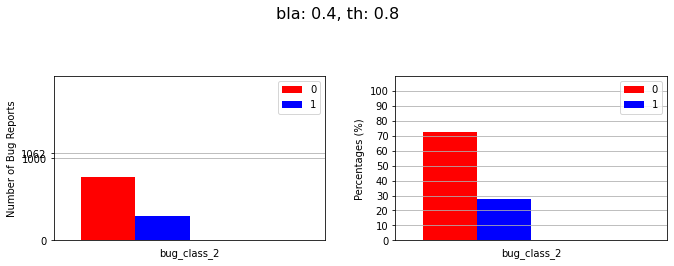

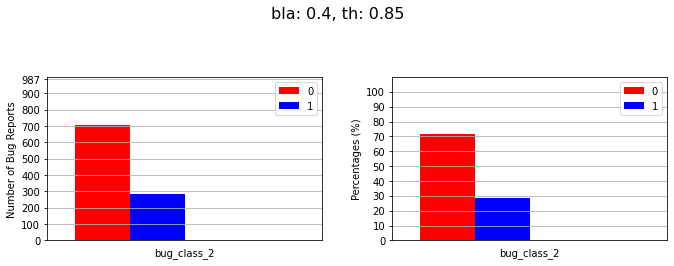

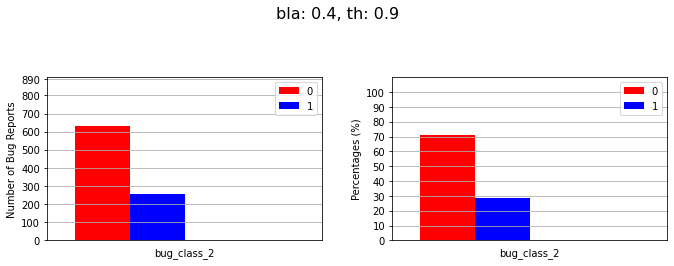

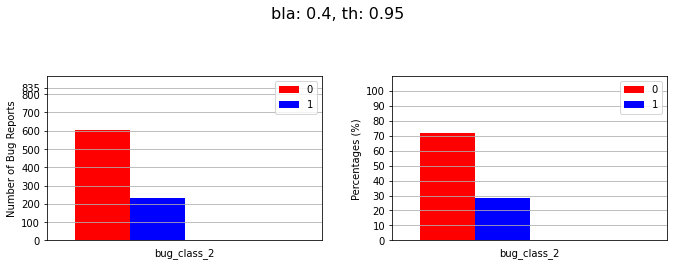

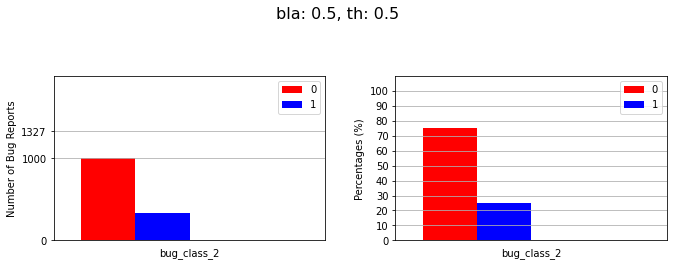

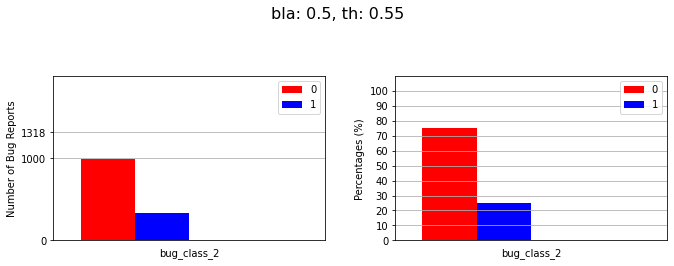

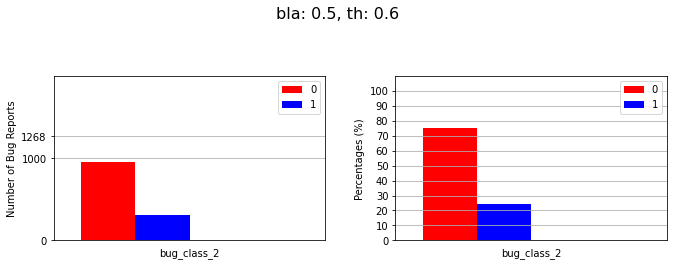

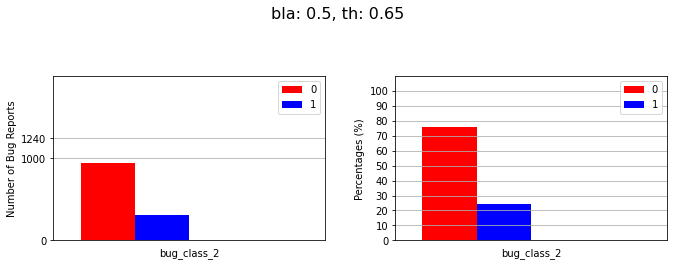

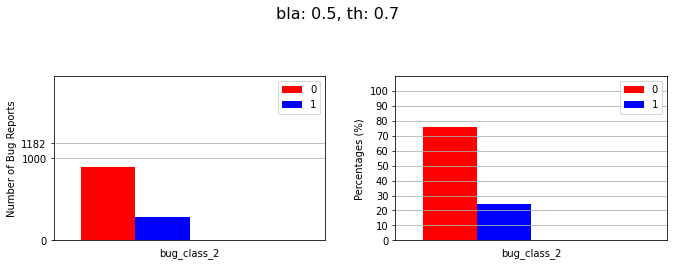

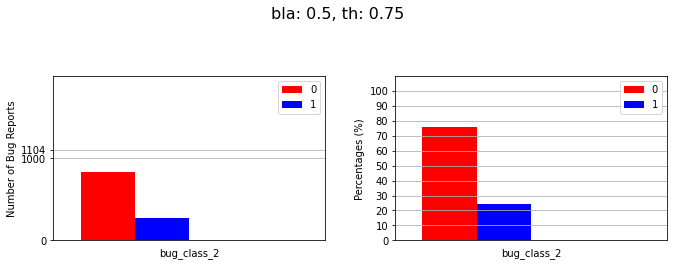

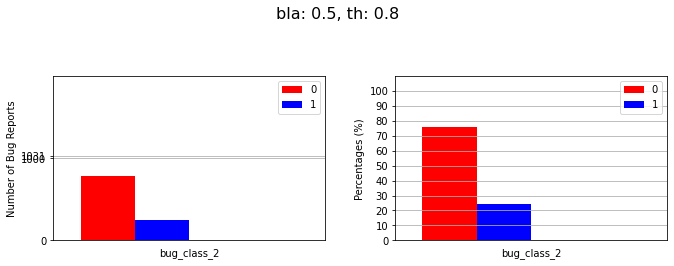

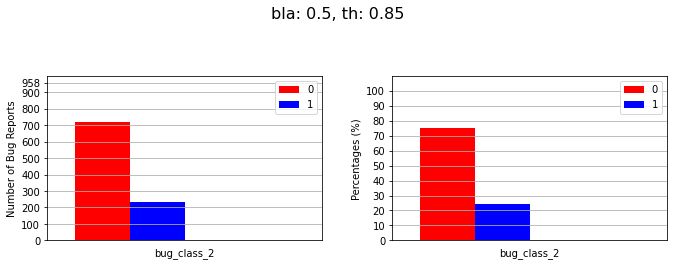

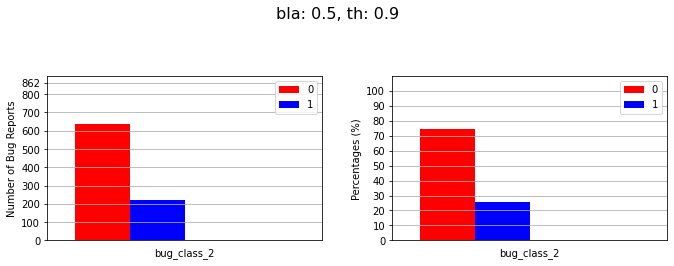

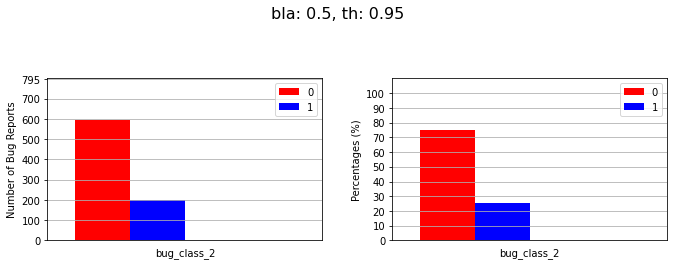

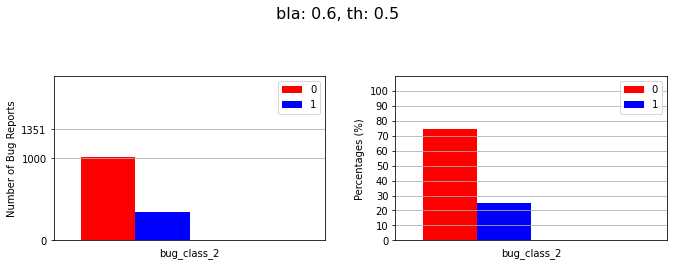

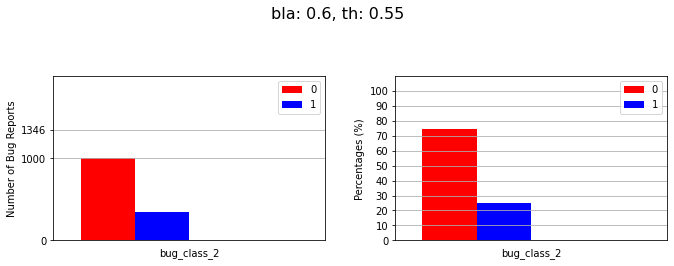

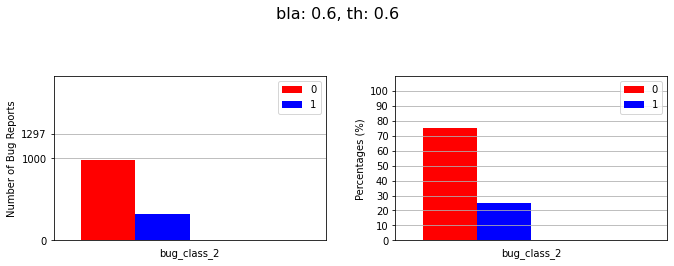

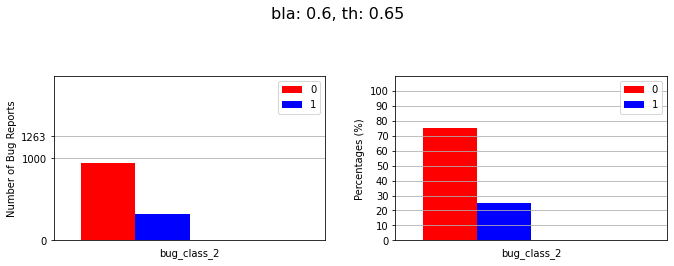

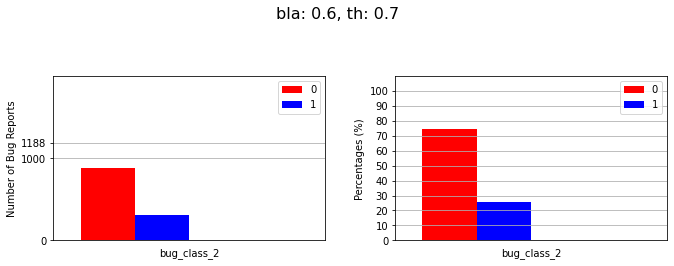

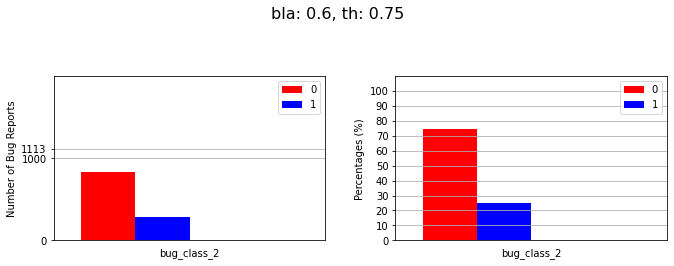

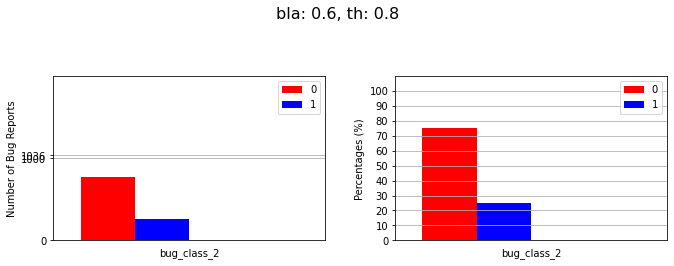

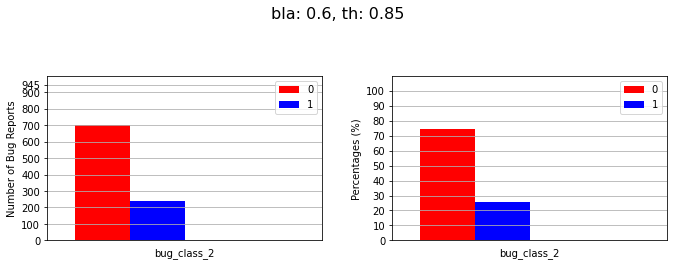

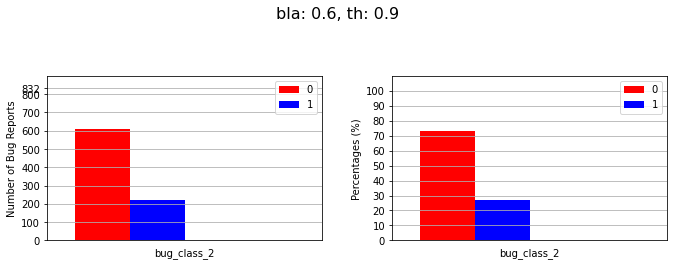

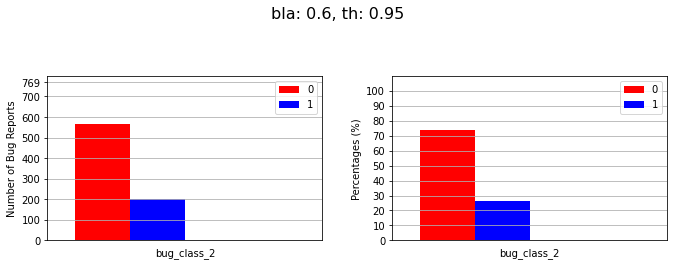

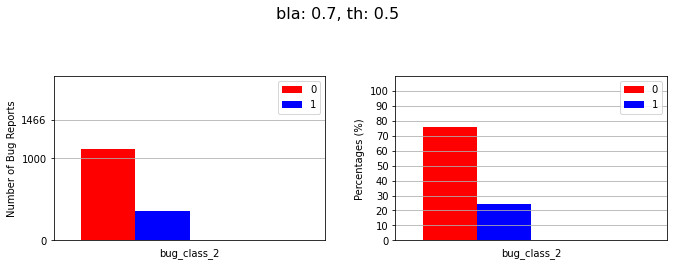

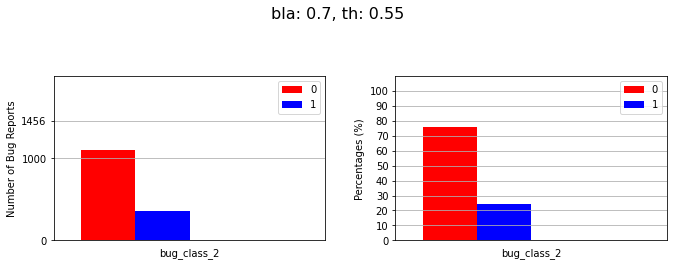

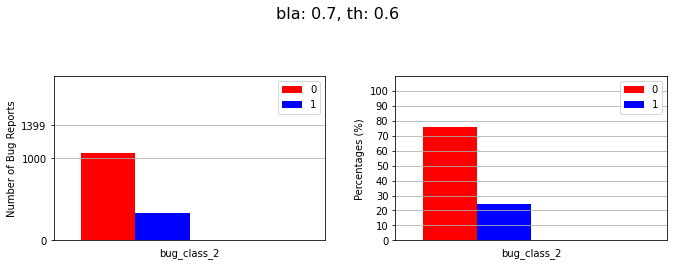

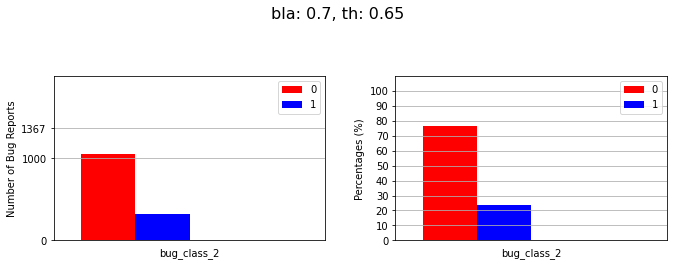

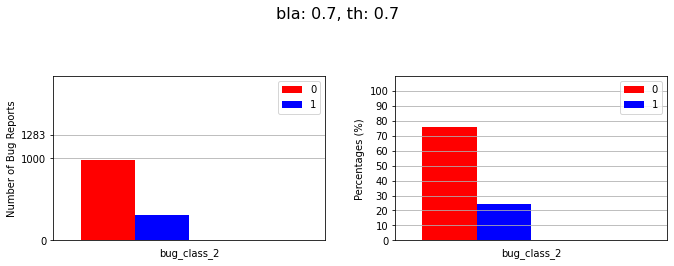

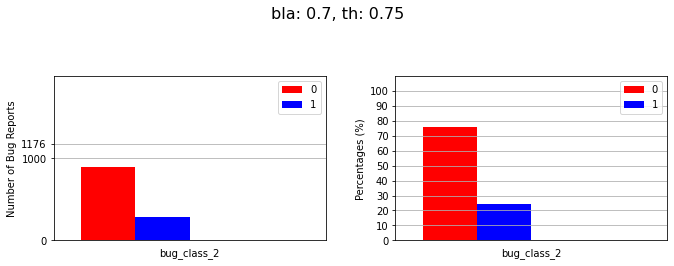

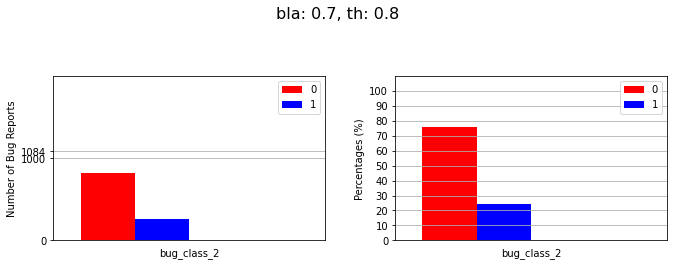

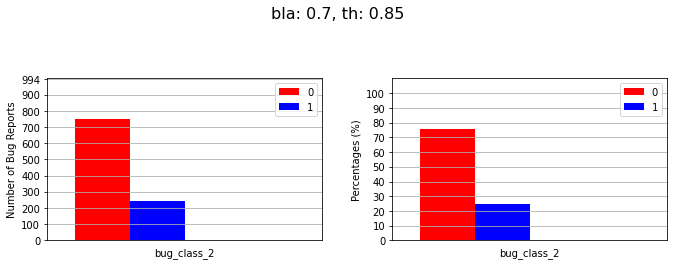

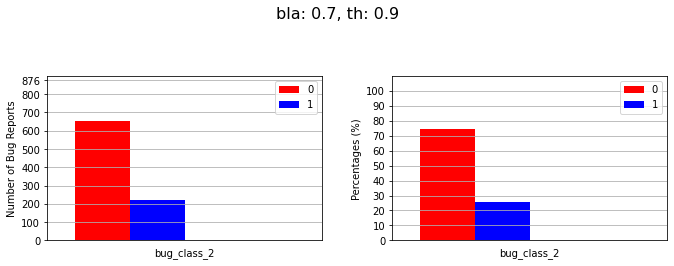

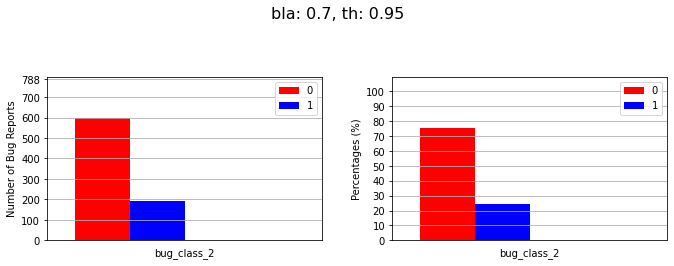

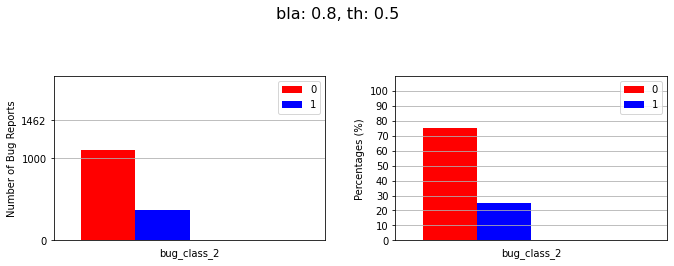

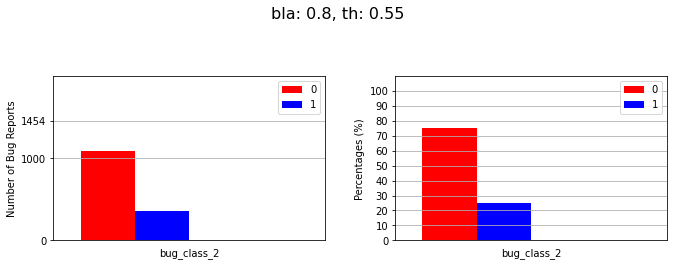

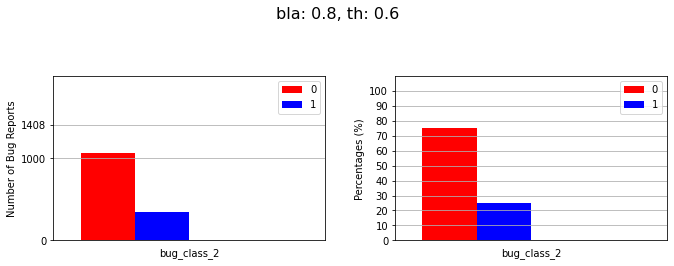

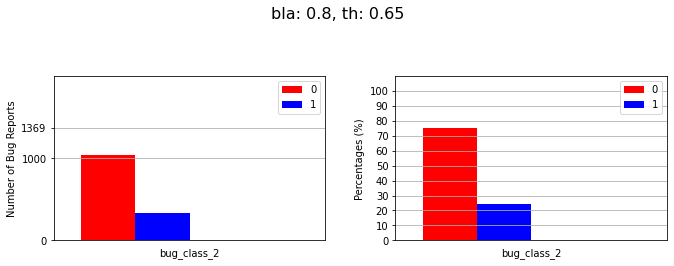

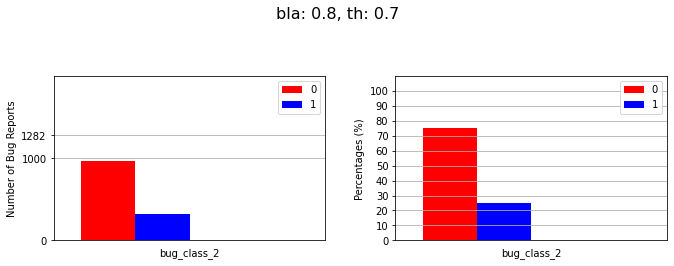

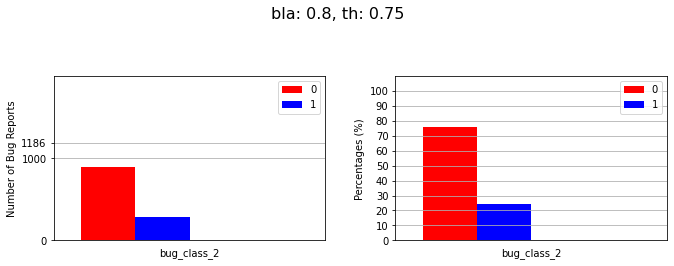

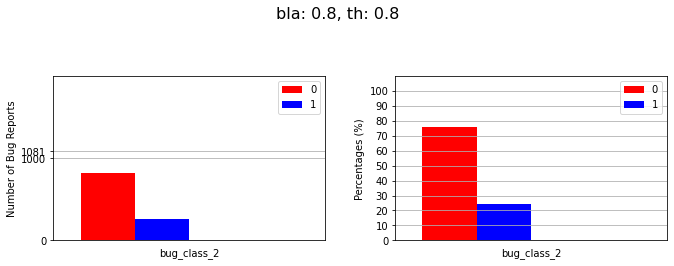

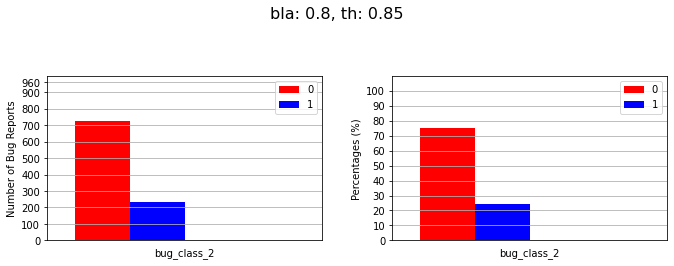

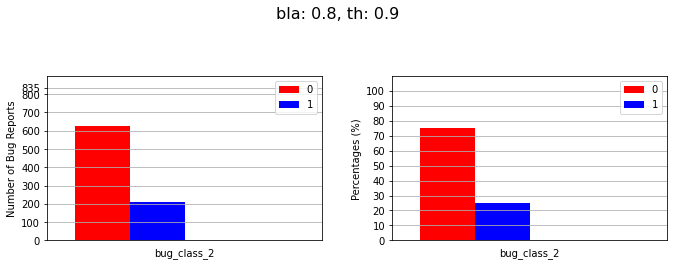

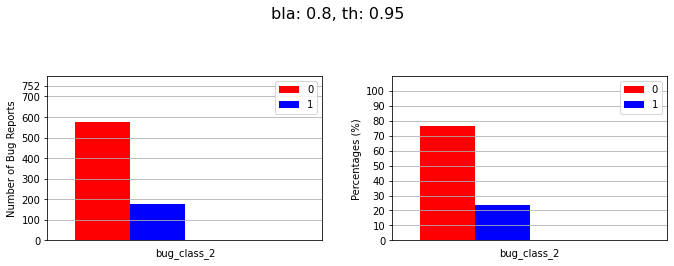

In [ ]:
pr.plot_class_distribution()